In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from os.path import join, abspath
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [3]:
import sys
sys.path.insert(0, abspath("./../../"))

In [4]:
from utils.pandas import apply_filters
from utils_local import colors_v1, read_spreadsheet

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Create dataframe

In [173]:
df = pd.DataFrame(
    {
        "group": ["Kinetics-400", "UCF-101", "NTU-60", "Gym-99", "SS-v2", "EPIC-Kitchens-100", "Charades", "AVA"],
        "Label overlap (\%)": [100.0, 80.0, 30.0, 0.0, 0.0, 0.0, 10.0, 35.0],
        "PoV": ["Third", "Third", "Third", "Third", "First", "First", "Third", "Third"],
        "Environment": ["Varied", "Varied", "Lab", "Stadium", "Household", "Kitchen", "Household", "Films"],
        "Action \\\ length (sec)": [10.0, 7.21, 2.82, 1.75, 3.80, 3.19, 12.8, 2.70],
        "Temporal \\\ awareness (sec)": [10, 7, 9, 9, 22, 32, 32, 12],
    }
)

In [174]:
df

,group,Label overlap (\%),PoV,Environment,Action \\ length (sec),Temporal \\ awareness (sec)
0,Kinetics-400,100.0,Third,Varied,10.00,10
1,UCF-101,80.0,Third,Varied,7.21,7
2,NTU-60,30.0,Third,Lab,2.82,9
3,Gym-99,0.0,Third,Stadium,1.75,9
4,SS-v2,0.0,First,Household,3.80,22
5,EPIC-Kitchens-100,0.0,First,Kitchen,3.19,32
6,Charades,10.0,Third,Household,12.80,32
7,AVA,35.0,Third,Films,2.70,12


In [175]:
# convert environment to scalar quantities

env_to_int = {
    "Varied": 0.1,
    "Films": 0.2,
    "Stadium": 0.3,
    "Lab": 0.4,
    "Household": 0.5,
    "Kitchen": 0.6,
}

df["Environment"].replace(env_to_int, inplace=True)

In [176]:
df

,group,Label overlap (\%),PoV,Environment,Action \\ length (sec),Temporal \\ awareness (sec)
0,Kinetics-400,100.0,Third,0.1,10.00,10
1,UCF-101,80.0,Third,0.1,7.21,7
2,NTU-60,30.0,Third,0.4,2.82,9
3,Gym-99,0.0,Third,0.3,1.75,9
4,SS-v2,0.0,First,0.5,3.80,22
5,EPIC-Kitchens-100,0.0,First,0.6,3.19,32
6,Charades,10.0,Third,0.5,12.80,32
7,AVA,35.0,Third,0.2,2.70,12


In [177]:
# convert PoV to scalar quantities

pov_to_int = {
    "Third": 0.1,
    "First": 0.7,
}

df["PoV"].replace(pov_to_int, inplace=True)

In [178]:
df

,group,Label overlap (\%),PoV,Environment,Action \\ length (sec),Temporal \\ awareness (sec)
0,Kinetics-400,100.0,0.1,0.1,10.00,10
1,UCF-101,80.0,0.1,0.1,7.21,7
2,NTU-60,30.0,0.1,0.4,2.82,9
3,Gym-99,0.0,0.1,0.3,1.75,9
4,SS-v2,0.0,0.7,0.5,3.80,22
5,EPIC-Kitchens-100,0.0,0.7,0.6,3.19,32
6,Charades,10.0,0.1,0.5,12.80,32
7,AVA,35.0,0.1,0.2,2.70,12


In [179]:
df.set_index("group", inplace=True)

In [180]:
df

,Label overlap (\%),PoV,Environment,Action \\ length (sec),Temporal \\ awareness (sec)
group,,,,,
Kinetics-400,100.0,0.1,0.1,10.00,10
UCF-101,80.0,0.1,0.1,7.21,7
NTU-60,30.0,0.1,0.4,2.82,9
Gym-99,0.0,0.1,0.3,1.75,9
SS-v2,0.0,0.7,0.5,3.80,22
EPIC-Kitchens-100,0.0,0.7,0.6,3.19,32
Charades,10.0,0.1,0.5,12.80,32
AVA,35.0,0.1,0.2,2.70,12


In [181]:
# normalize df s.t. each column has values between min and max

from sklearn import preprocessing

min_val = 0.1
max_val = 1.1

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.3, 1.0))
x_scaled = min_max_scaler.fit_transform(x)
# pd.DataFrame(x_scaled)

df_scaled = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

# invert label overlap (since we want 100% to be at origin)
label_overlap_column = [x for x in list(df.columns) if x.startswith("Label")][0]
df_scaled[label_overlap_column] = 1 - df_scaled[label_overlap_column]

In [182]:
label_overlap_column

'Label overlap (\\%)'

In [183]:
df_scaled

,Label overlap (\%),PoV,Environment,Action \\ length (sec),Temporal \\ awareness (sec)
group,,,,,
Kinetics-400,0.000,0.3,0.30,0.822624,0.384
UCF-101,0.140,0.3,0.30,0.645882,0.300
NTU-60,0.490,0.3,0.72,0.367783,0.356
Gym-99,0.700,0.3,0.58,0.300000,0.356
SS-v2,0.700,1.0,0.86,0.429864,0.720
EPIC-Kitchens-100,0.700,1.0,1.00,0.391222,1.000
Charades,0.630,0.3,0.86,1.000000,1.000
AVA,0.455,0.3,0.44,0.360181,0.440


In [184]:
def embolden(string):
    return "\\textbf{%s}" % string

In [192]:
colormap = {
    "Kinetics-400": ("gray", "darkgray", 0.15),
    "UCF-101": ("yellow", "darkgoldenrod", 0.3),
    "NTU-60": ("lightgreen", "green", 0.3),
    "SS-v2": ("pink", "red", 0.3),
    "Gym-99": ("violet", "indigo", 0.1),
    "EPIC-Kitchens-100": ("lightcyan", "darkblue", 0.3),
    "Charades": ("peachpuff", "chocolate", 0.3),
    "AVA": ("greenyellow", "olive", 0.1),
}

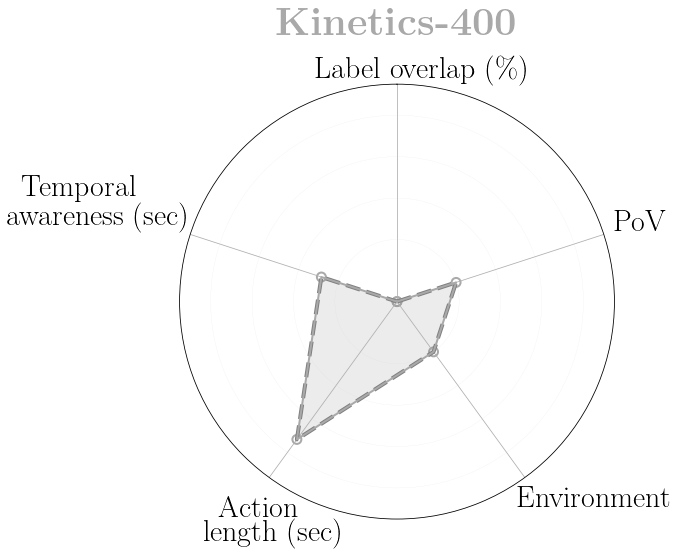

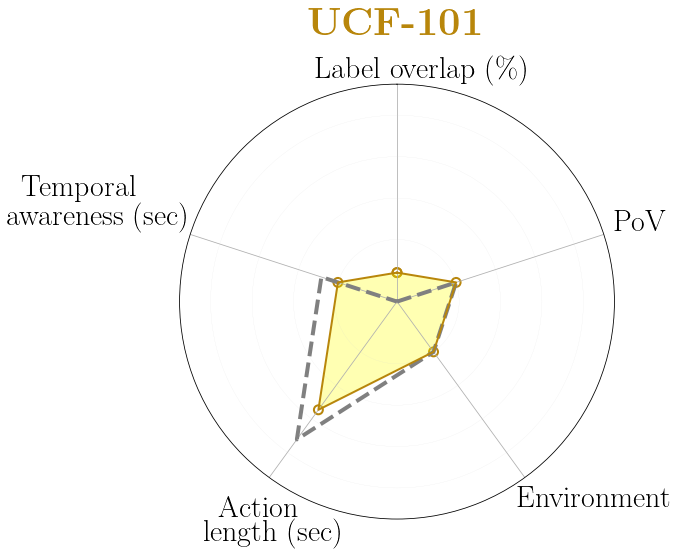

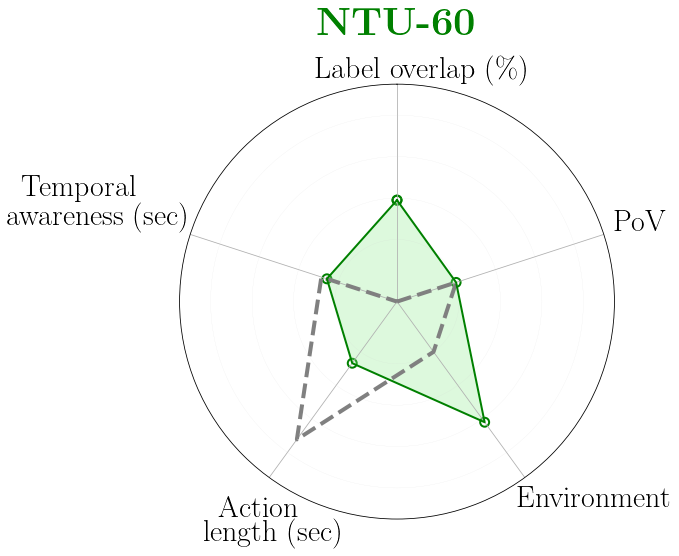

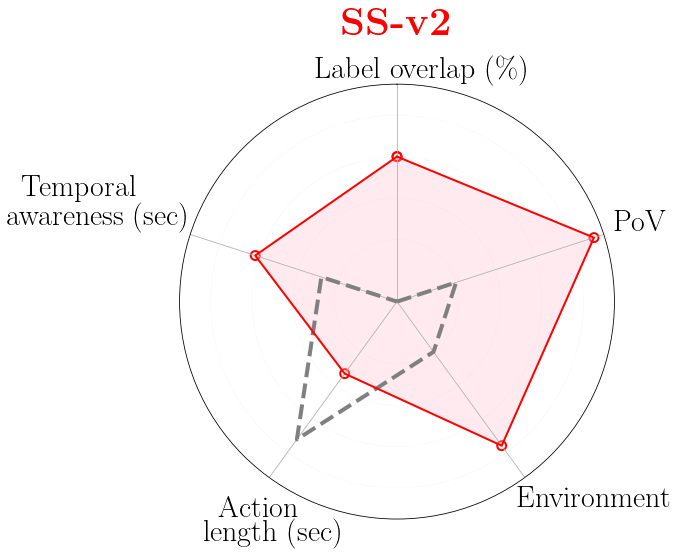

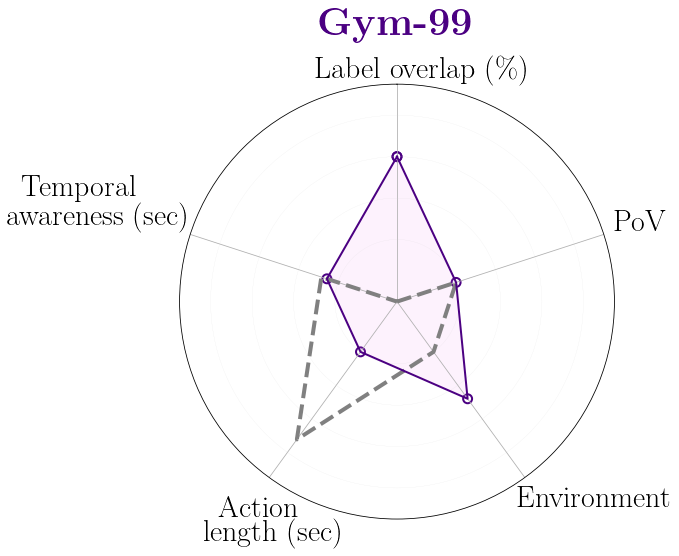

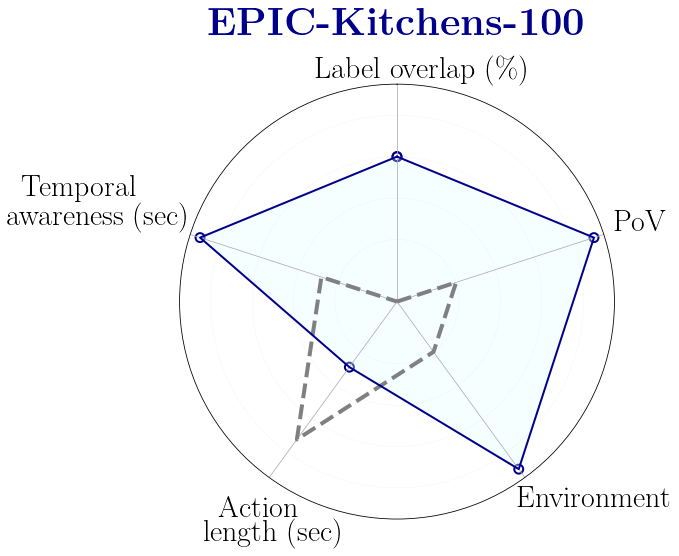

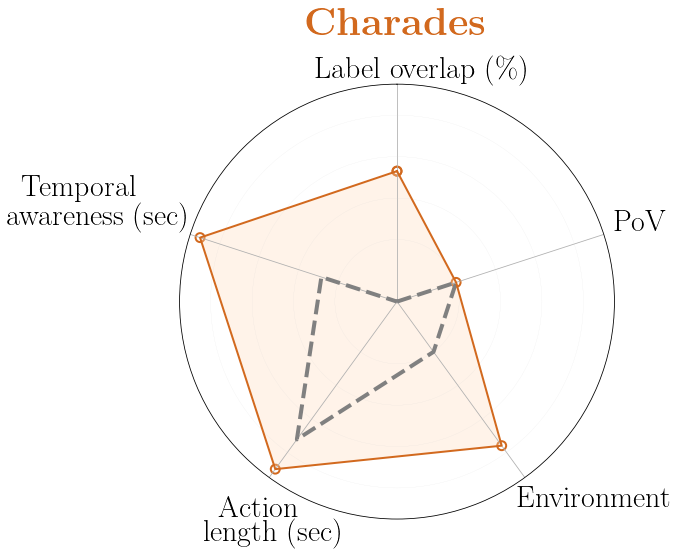

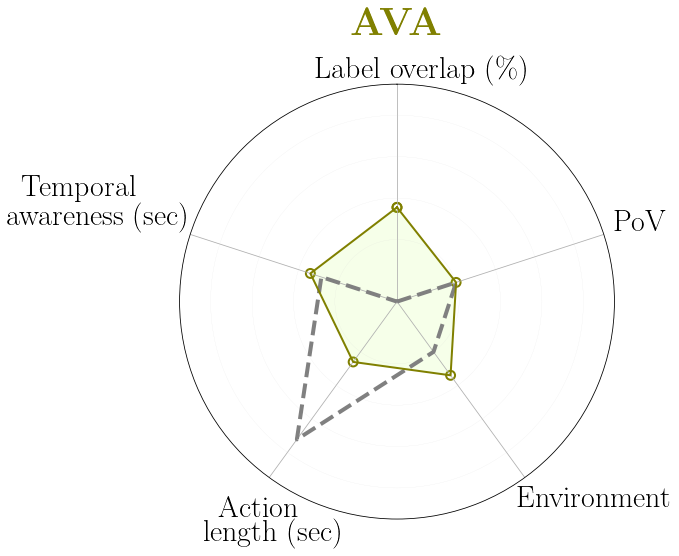

In [227]:
# define variables
# dataset = "UCF-101"
# dataset = "NTU-60"
# dataset = "SS-v2"
# dataset = "Gym-99"
# dataset = "EPIC-Kitchens-100"
# dataset = "Charades"
# dataset = "AVA"
# dataset = "Kinetics-400"

reference_dataset = "Kinetics-400"
reference_line_config = {
    "color": "gray",
    "linewidth": 4.,
}

# define constants
titlesize = 40
tickssize = 0.75 * titlesize

for dataset in colormap:


    # ------- PART 1: Create background

    # number of variable
    categories=list(df_scaled)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    f = plt.figure(figsize=(8,8))
    ax = f.add_subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_ylim(0.,1.05)

    # Draw one axe per variable + add labels
    bold_categories = [embolden(x) for x in categories]
    plt.xticks(angles[:-1], categories, fontsize=tickssize)

    # Draw ylabels
    plt.yticks([0.3,0.5,0.7,0.9], ["","","", ""], color="grey", size=7) 

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values=df_scaled.loc[reference_dataset].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=reference_line_config["linewidth"], linestyle='dashed', label="Kinetics", color=reference_line_config["color"])
    ax.fill(angles, values, reference_line_config["color"], alpha=0.0)

    # Ind2
    facecolor, linecolor, facealpha = colormap[dataset]
    values=df_scaled.loc[dataset].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2.0, linestyle='solid', label="UCF-101", color=linecolor)
    ax.scatter(angles, values, linewidth=2.0, linestyle='solid', label="UCF-101", color=linecolor, facecolor="none", s=80)
    ax.fill(angles, values, facecolor, alpha=facealpha)

    # Add legend
    # plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # make gridlines light
    gridlines = ax.yaxis.get_gridlines()
    for i in range(len(ax.get_yticks())):
        gridlines[i].set_color("lightgray")
        gridlines[i].set_linewidth(0.1)

    thetas = ax.get_xticks()
    if titlesize < 25:
        rdeltas = [0.08, 0.05, 0.08, 0.23, 0.53]
    elif titlesize == 35:
        rdeltas = [0.1, 0.05, 0.1, 0.3, 0.75]
    elif titlesize == 40:
        rdeltas = [0.1, 0.05, 0.1, 0.35, 0.9]
    ax.text(-0.35, ax.get_ylim()[1] + rdeltas[0], s=categories[0], fontsize=tickssize)
    ax.text(thetas[1], ax.get_ylim()[1] + rdeltas[1], s=categories[1], fontsize=tickssize)
    ax.text(thetas[2] + 0.1, ax.get_ylim()[1] + rdeltas[2], s=categories[2], fontsize=tickssize)
    ax.text(thetas[3] + 0.1, ax.get_ylim()[1] + rdeltas[3], s=categories[3], fontsize=tickssize)
    ax.text(thetas[4] - 0.05, ax.get_ylim()[1] + rdeltas[4], s=categories[4], fontsize=tickssize)

    ax.set_xticklabels([])
    # Show the graph
    plt.title(embolden(dataset), y=1.1, fontsize=titlesize, color=linecolor)

    plt.savefig(f"../../results/plots/radar_{dataset}_v2.pdf", bbox_inches="tight")
    plt.show()

### Demo

In [51]:
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})

In [52]:
df

,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


In [54]:
df

,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


In [55]:
angles

[0.0,
 1.2566370614359172,
 2.5132741228718345,
 3.7699111843077517,
 5.026548245743669,
 0.0]

In [56]:
values

[1.5, 10, 39, 31, 15, 1.5]

In [59]:
values=df.loc[1].drop('group').values.flatten().tolist()


In [60]:
values

[1.5, 10, 39, 31, 15]

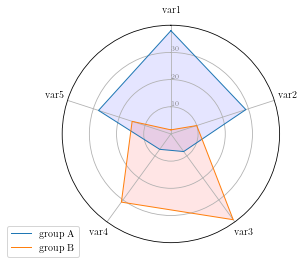

In [53]:
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()
